# Classification - Analyze

In [3]:
import yaml
import os
import shutil
import subprocess
import datetime
import numpy
import random
import sklearn.metrics
import tensorflow

print("INFO> TensorFlow version: %s" % tensorflow.__version__)
print("INFO> Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

INFO> TensorFlow version: 1.14.0
INFO> Num GPUs Available:  0


In [4]:
# Read parameters from local config.yaml file, and update corresponding Python variables
currentDir = os.getcwd()
print("INFO> Reading file config.yam from directory: %s" % currentDir)
yamlFile = open('config.yaml','r')
yamlData = yaml.load(yamlFile,Loader=yaml.Loader)

for key in sorted(yamlData):
    print("INFO> %-15s: %s" % (key,yamlData[key]))

batchSize = yamlData['batchSize']
checkDataset = yamlData['checkDataset']
checkpointDir = yamlData['checkpointDir']
createDataset = yamlData['createDataset']
datasetDir = yamlData['datasetDir']
goldenDataset = yamlData['goldenDataset']
imageHeight = yamlData['imageHeight']
imageWidth = yamlData['imageWidth']
learningRate = float(yamlData['learningRate'])
logDir = yamlData['logDir']
nEpochs = yamlData['nEpochs']
nTrnSamples = yamlData['nTrnSamples']
nTstSamples = yamlData['nTstSamples']
nValSamples = yamlData['nValSamples']
remDir = os.path.join(yamlData['datasetDir'], yamlData['remDir'])
tmpDir = os.path.join(yamlData['datasetDir'], yamlData['tmpDir'])
trnDir = os.path.join(yamlData['datasetDir'], yamlData['trnDir'])
tstDir = os.path.join(yamlData['datasetDir'], yamlData['tstDir'])
valDir = os.path.join(yamlData['datasetDir'], yamlData['valDir'])

INFO> Reading file config.yam from directory: /raid5/disk1/mlproj10/classification
INFO> batchSize      : 16
INFO> checkDataset   : True
INFO> checkpointDir  : /home/jmv/data/mlproj10/tmp/
INFO> createDataset  : True
INFO> datasetDir     : /home/jmv/data/mlproj10/dataset
INFO> goldenDataset  : /home/jmv/data/mlproj10/LeryPosesGolden/dataset
INFO> imageHeight    : 720
INFO> imageWidth     : 1280
INFO> learningRate   : 1e-6
INFO> logDir         : /home/jmv/data/mlproj10/log/
INFO> nEpochs        : 1000
INFO> nTrnSamples    : 2000
INFO> nTstSamples    : 671
INFO> nValSamples    : 671
INFO> remDir         : rem
INFO> tmpDir         : tmp
INFO> trnDir         : trn
INFO> tstDir         : tst
INFO> valDir         : val


In [5]:
# Look in the tmp directory and select best model candidate based on train/val loss & accuracy
# For TF1.14, added compile=False. This is not needed for TF2
model = tensorflow.keras.models.load_model('/home/jmv/data/mlproj1/tmp/V6_large_with_dropout_lr_1e_6/weights_windsurf_V1_0109_0.087_0.975_0.124_0.961.h5', compile=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
tstDataGen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

tstGenerator = tstDataGen.flow_from_directory(
    directory=tstDir,
    target_size=(imageHeight,imageWidth),
    batch_size=1,
    class_mode=None,
    shuffle=False)

# Confusion matrix
predictions = model.predict_generator(tstGenerator,numpy.math.ceil(tstGenerator.samples/tstGenerator.batch_size))
images = tstGenerator.filenames
trueClasses = tstGenerator.classes
# The line below is right for multi class classification
# predictedClasses = numpy.argmax(predictions, axis=1)
# The line below is valid for binary classification
predictedClasses = [0 if prediction<0.5 else 1 for prediction in predictions]
report = sklearn.metrics.confusion_matrix(trueClasses, predictedClasses)

print(tstGenerator.class_indices)
print(report)

# List images which have a different predicted class vs. true class
for image, trueClass, predictedClass in zip(images,trueClasses,predictedClasses):
    if trueClass!=predictedClass:
        print("Image: %s, True Class: %d, Predicted Class: %d" % (image, trueClass, predictedClass))

Found 1342 images belonging to 2 classes.
{'0windsurf': 0, '1windsurf': 1}
[[662   9]
 [ 31 640]]
Image: 0windsurf/201604151345.jpg, True Class: 0, Predicted Class: 1
Image: 0windsurf/201604151430.jpg, True Class: 0, Predicted Class: 1
Image: 0windsurf/201604151448.jpg, True Class: 0, Predicted Class: 1
Image: 0windsurf/201604201753.jpg, True Class: 0, Predicted Class: 1
Image: 0windsurf/201604281608.jpg, True Class: 0, Predicted Class: 1
Image: 0windsurf/201606251644.jpg, True Class: 0, Predicted Class: 1
Image: 0windsurf/201703251215.jpg, True Class: 0, Predicted Class: 1
Image: 0windsurf/201710211311.jpg, True Class: 0, Predicted Class: 1
Image: 0windsurf/201710241252.jpg, True Class: 0, Predicted Class: 1
Image: 1windsurf/201602071257.jpg, True Class: 1, Predicted Class: 0
Image: 1windsurf/201602071450.jpg, True Class: 1, Predicted Class: 0
Image: 1windsurf/201602091154.jpg, True Class: 1, Predicted Class: 0
Image: 1windsurf/201602201220.jpg, True Class: 1, Predicted Class: 0
Image

In [20]:
remDataGen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

remGenerator = remDataGen.flow_from_directory(
    directory=remDir,
    target_size=(imageHeight,imageWidth),
    batch_size=1,
    class_mode=None,
    shuffle=False)

# Confusion matrix
predictions = model.predict_generator(remGenerator,numpy.math.ceil(remGenerator.samples/remGenerator.batch_size))
images = remGenerator.filenames
trueClasses = remGenerator.classes
# this line was used for multi class classification
# predictedClasses = numpy.argmax(predictions, axis=1)
# The line below is used for binary classification
predictedClasses = [0 if prediction<0.5 else 1 for prediction in predictions]
report = sklearn.metrics.confusion_matrix(trueClasses, predictedClasses)

print(remGenerator.class_indices)
print(report)

for image, trueClass, predictedClass in zip(images,trueClasses,predictedClasses):
    if trueClass!=predictedClass:
        print("Image: %s, True Class: %d, Predicted Class: %d" % (image, trueClass, predictedClass))

Found 430 images belonging to 2 classes.
{'0windsurf': 0, '1windsurf': 1}
[[411   3]
 [  0  16]]
Image: 0windsurf/201611201005.jpg, True Class: 0, Predicted Class: 1
Image: 0windsurf/201611201318.jpg, True Class: 0, Predicted Class: 1
Image: 0windsurf/201710201448.jpg, True Class: 0, Predicted Class: 1


In [29]:
# From book \"Deep Learning w/ Python\" by François Chollet
# From https://stackoverflow.com/questions/58322147/how-to-generate-cnn-heatmaps-using-built-in-keras-in-tf2-0-tf-keras
import matplotlib.pyplot
import cv2
import PIL

def plot_activation(imagePath):
    # Loads an image into PIL format
    myImage = tensorflow.keras.preprocessing.image.load_img(imagePath,target_size=(imageHeight,imageWidth))
    # Converts the PIL image into a Numpy array
    myImageAsArray = tensorflow.keras.preprocessing.image.img_to_array(myImage)
    # Creates a list containing a single image [myImageAsArray]
    myImageAsArray = numpy.expand_dims(myImageAsArray,axis=0)
    # Scales the image in the same way as what we did before the training
    myImageAsArray /= 255.0
    # Gets the result of the model    
    myPrediction = model.predict(myImageAsArray)    
    #myPredictedClass = numpy.argmax(myPrediction, axis=1)    
    myPredictedClass = [0 if myPrediction<0.5 else 1]
    #print(f\"DBG> Predicted class: {myPredictedClass[0]}\")    
    #    
    convLayer = model.get_layer("conv2d_5")    
    #print("DBG> convLayer is",convLayer)    
    modelOutput = model.output[:,myPredictedClass[0]]    
    # Was forced to add tensorflow.cast(...,'float32') because otherwise the tensor is missing    
    # dtype set to float32. Bug with TF1.14?    
    #grads = tensorflow.cast(tensorflow.keras.backend.gradients(modelOutput,convLayer.output),'float32')    
    grads = tensorflow.keras.backend.gradients(modelOutput,convLayer.output)[0]    
    pooledGrads = tensorflow.keras.backend.mean(grads,axis=(0,1,2))    
    iterate = tensorflow.keras.backend.function([model.input],[pooledGrads,convLayer.output[0]])    
    pooledGradsValue, convLayerOutputValue = iterate([myImageAsArray])    
    numberOfChannelsConvLayer = convLayer.output[0].get_shape()[2]    
    for i in range(numberOfChannelsConvLayer):    
        convLayerOutputValue[:,:,i] *= pooledGradsValue[i]    
    heatMap = numpy.mean(convLayerOutputValue, axis=-1)    
    heatMap = numpy.maximum(heatMap,0)    
    heatMap /= numpy.max(heatMap)    
    matplotlib.pyplot.matshow(heatMap)    
    #    
    img = cv2.imread(imagePath)    
    heatMap = cv2.resize(heatMap,(img.shape[1],img.shape[0]))    
    heatMap =numpy.uint8(255*heatMap)    
    heatMap = cv2.applyColorMap(heatMap,cv2.COLORMAP_JET)    
    superImposedImg = heatMap*0.4+img    
    cv2.imwrite('/home/jmv/data/mlproj10/myresultingimage.jpg',superImposedImg)

DBG> Desired number of images: 10
DBG> Directory to display images from: /home/jmv/data/mlproj10/dataset/tst
DBG> Class=0windsurf
DBG> Actual number of images: 671
DBG> Image: 201601231451.jpg
DBG> Image: 201601231718.jpg
DBG> Image: 201601241722.jpg
DBG> Image: 201601250901.jpg
DBG> Image: 201601251005.jpg
DBG> Image: 201601251107.jpg
DBG> Image: 201601251445.jpg
DBG> Image: 201601251524.jpg
DBG> Image: 201601251545.jpg
DBG> Image: 201601251658.jpg
DBG> Class=1windsurf
DBG> Actual number of images: 671
DBG> Image: 201602061113.jpg


ValueError: slice index 1 of dimension 1 out of bounds. for 'strided_slice_30' (op: 'StridedSlice') with input shapes: [?,1], [2], [2], [2] and with computed input tensors: input[1] = <0 1>, input[2] = <0 2>, input[3] = <1 1>.

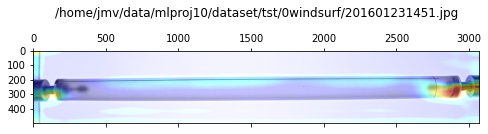

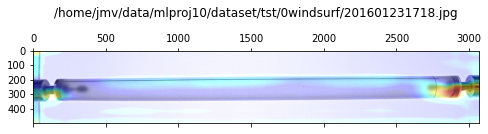

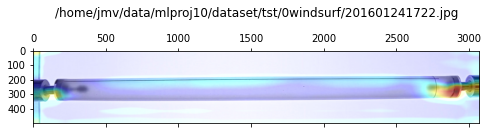

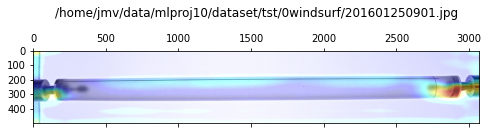

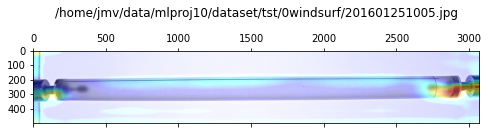

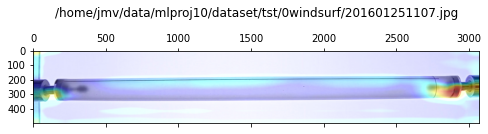

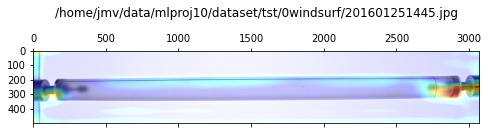

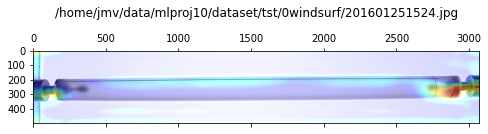

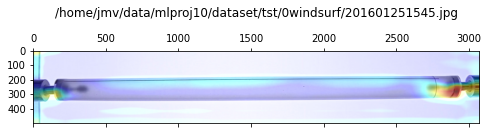

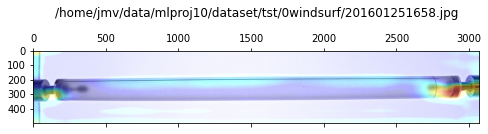

In [30]:
desiredNumberOfImagesToDisplay = 10    
dirToDisplayFrom = tstDir    
print(f"DBG> Desired number of images: {desiredNumberOfImagesToDisplay}")    
print(f"DBG> Directory to display images from: {dirToDisplayFrom}")    
  
for myClass in sorted(os.listdir(dirToDisplayFrom)):    
    print(f"DBG> Class={myClass}")    
    listOfImages = [image for image in sorted(os.listdir(os.path.join(tstDir,myClass))) if "copy" not in image]    
    actualNumberOfImagesToDisplay = len(listOfImages)    
    print(f"DBG> Actual number of images: {actualNumberOfImagesToDisplay}")    
    for image in listOfImages[:min(desiredNumberOfImagesToDisplay,actualNumberOfImagesToDisplay)]:    
        print(f"DBG> Image: {image}")    
        selectImage = os.path.join(tstDir,myClass,image)    
        plot_activation(selectImage)    
        pil_img = PIL.Image.open('/home/jmv/data/mlproj8/myresultingimage.jpg')    
        myImShow = matplotlib.pyplot.imshow(pil_img)    
        matplotlib.pyplot.title(selectImage,pad=30)    

In [ ]:
import PIL

imgdir = os.path.join(tstDir,"0windsurf")
files  = os.listdir(imgdir)
FP = 0
for f in files:
    tmppic = PIL.Image.open(os.path.join(imgdir,f))
    tmparr = numpy.array(tmppic.getdata()).reshape(tmppic.size[1], tmppic.size[0], 3)
    [[result]] = model.predict(tmparr[None,:,:,:]/255.0)
    
    if result>0.5:
        print("nowindsurfers> "+f+" "+str(result))
        FP +=1 
        #IPython.display.display(IPython.display.Image(imgdir+f))


imgdir = os.path.join(tstDir,"1windsurf")
files  = os.listdir(imgdir)
FN = 0
for f in files:
    tmppic = PIL.Image.open(os.path.join(imgdir,f))
    tmparr = numpy.array(tmppic.getdata()).reshape(tmppic.size[1], tmppic.size[0], 3)
    [[result]] = model.predict(tmparr[None,:,:,:]/255.0)
    if result<0.5:
        print("windsurfers> "+f+" "+str(result))
        FN +=1 
        #IPython.display.display(IPython.display.Image(imgdir+f))

print("False Positive: "+str(FP))
print("False Negative: "+str(FN))
print("Accuracy      :"+str(100-100*(FP+FN)/2.0/len(files)))

In [7]:
print(len(predictions)//2)
for p in predictions:
    print(p)

671
[2.081554e-05]
[0.14471275]
[1.6968617e-05]
[0.04191212]
[0.00025517]
[0.00012801]
[0.00123022]
[0.00066651]
[0.00112727]
[3.22339e-05]
[8.8455035e-06]
[0.00017667]
[1.6380423e-05]
[0.00013927]
[0.00567775]
[3.6498506e-07]
[1.9622755e-07]
[0.00160264]
[0.00015029]
[5.914489e-05]
[1.1266363e-05]
[7.971607e-06]
[8.5190695e-06]
[9.493446e-06]
[8.937419e-07]
[2.4690598e-06]
[7.127544e-06]
[5.326693e-06]
[1.2659611e-06]
[1.2484729e-05]
[9.618376e-06]
[0.41147447]
[0.00159867]
[0.00182611]
[0.00076066]
[4.70667e-05]
[0.01210383]
[0.00301899]
[0.0022902]
[3.9909257e-05]
[0.00941751]
[0.00779812]
[0.0002142]
[0.00033443]
[0.00155181]
[0.00245622]
[0.00089493]
[0.00025194]
[0.00391131]
[5.095493e-06]
[2.8747743e-05]
[0.00226579]
[0.00046425]
[0.00074318]
[0.01339129]
[0.0002424]
[0.00053671]
[0.00123454]
[0.00139555]
[0.0007884]
[0.00015606]
[0.00099093]
[0.00046236]
[0.00039308]
[0.00025334]
[0.00358914]
[0.00652004]
[0.00053317]
[0.00035585]
[0.00094447]
[2.9645971e-06]
[1.5624928e-06]
[0

[0.0003754]
[8.202015e-05]
[0.00153973]
[0.00120675]
[0.00251689]
[4.08021e-06]
[6.38931e-07]
[1.8273242e-06]
[6.0946055e-05]
[0.00021713]
[0.00022079]
[0.00010656]
[9.093986e-06]
[0.00097949]
[0.00020013]
[0.00187485]
[0.00033481]
[4.0579675e-05]
[7.714176e-05]
[0.00154439]
[1.523259e-05]
[1.6964168e-05]
[0.00043062]
[0.00087834]
[5.164774e-06]
[7.0492904e-05]
[0.00026918]
[0.00016731]
[0.00146854]
[0.00013583]
[0.00026661]
[0.00109632]
[4.6920504e-06]
[0.00059857]
[0.0402077]
[0.00376264]
[0.00156297]
[0.00259485]
[0.0008147]
[0.00184085]
[0.00282405]
[0.00144038]
[0.00123832]
[0.00433502]
[0.00062412]
[0.00025399]
[8.0635386e-05]
[0.00016953]
[0.00049923]
[0.99969447]
[0.9990416]
[0.9999865]
[0.999824]
[0.999913]
[0.9994709]
[0.9999838]
[0.9933496]
[0.9999999]
[0.9610946]
[0.99967587]
[0.9991265]
[1.]
[0.97255695]
[0.9999193]
[0.9996531]
[0.6124671]
[0.88452053]
[0.97191995]
[0.46109545]
[0.625927]
[0.8701975]
[0.12339737]
[0.97884834]
[0.9999938]
[0.9999236]
[0.9971589]
[0.69215393

In [13]:
a = [0.1, 0.3, 0.6, 1.0]
print(a)
b = [(0 if i<0.5 else 1) for i in a]
print(b)

[0.1, 0.3, 0.6, 1.0]
[0, 0, 1, 1]


In [24]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 718, 1278, 64)     1792      
_________________________________________________________________
activation (Activation)      (None, 718, 1278, 64)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 718, 1278, 64)     256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 359, 639, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 357, 637, 128)     73856     
_________________________________________________________________
activation_1 (Activation)    (None, 357, 637, 128)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 357, 637, 128)     5